# The Validation partition of the dataset

This notebook presents some of the common practices in training a classification model, namely:

- use of a validation set
- early stopping
- learning rate scheduler

# Auxiliary Function

In [21]:
import torch
import torchvision
import torchvision.transforms as transforms

import torchinfo

import matplotlib.pyplot as plt
import numpy as np
import time

# importing a module with utilities for displaying stats and data
import sys
sys.path.insert(1, '../util')
import vcpi_util

In [22]:
def evaluate(model, data_loader):

    # sets the model in evaluation mode.
    # although our model does not have layers which behave differently during training and evaluation
    # this is a good practice as the models architecture may change in the future
    model.eval()

    correct = 0
    
    for i, (images, targets) in enumerate(data_loader):
         
        # forward pass, compute the output of the model for the current batch
        outputs = model(images.to(device))

        # "max" returns a namedtuple (values, indices) where values is the maximum 
        # value of each row of the input tensor in the given dimension dim; 
        # indices is the index location of each maximum value found (argmax).
        # the argmax effectively provides the predicted class number        
        _, preds = torch.max(outputs, dim=1)

        correct += (preds.cpu() == targets).sum()

    return (correct / len(data_loader.dataset)).item()


In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
BATCH_SIZE = 128
EPOCHS = 20

cpu


In [35]:
PATH_TRAINING_SET = './dataset/train'
PATH_TEST_SET = './dataset/test'

In [36]:
transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])


In [37]:
train_set = torchvision.datasets.ImageFolder(root=PATH_TRAINING_SET, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

test_set = torchvision.datasets.ImageFolder(root=PATH_TEST_SET, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

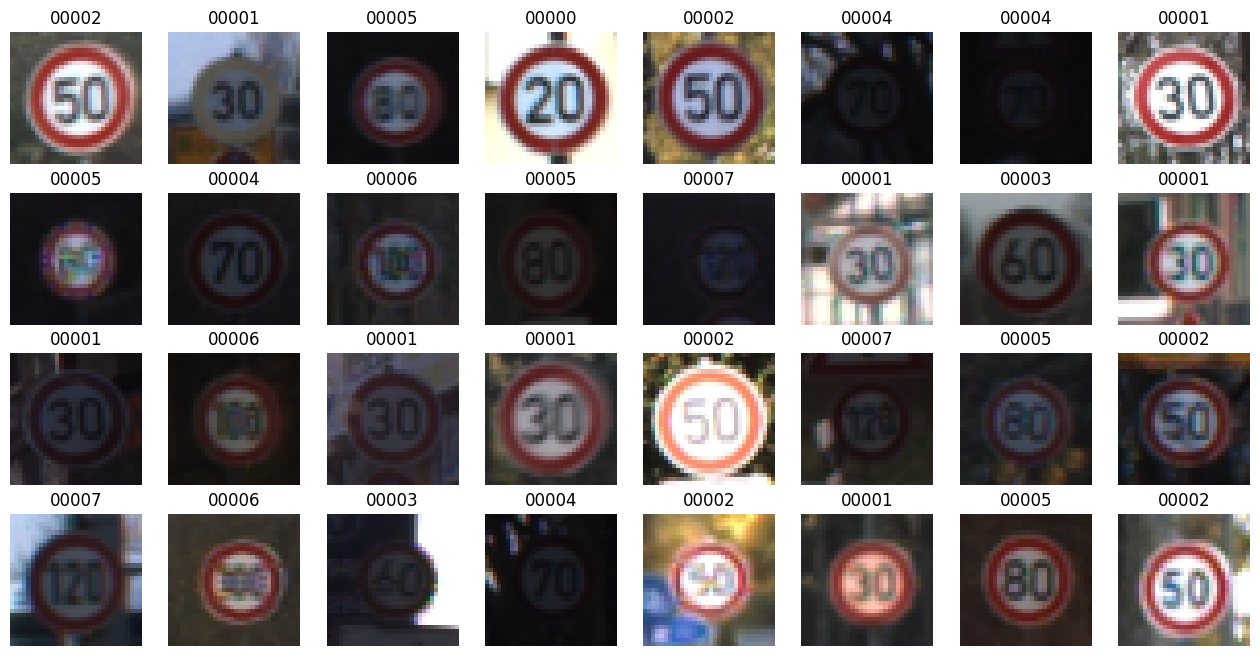

<Figure size 640x480 with 0 Axes>

In [38]:
images,targets = next(iter(train_loader))
vcpi_util.show_images(4,8,images,targets,train_set.classes)

In [39]:
def train(model,data_loader,epochs,loss_function, optimizer):
    model.train()
    history={}
    history['accuracy'] = []
    history['loss'] = []
    for epoch in range(epochs):
        start_time = time.time()
        correct = 0
        running_loss = 0
        
        for i, (inputs,targets) in enumerate(data_loader,0):
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            
            loss = loss_function(outputs,targets)
            optimizer.zero_grad()
            
            loss.backward()
            optimizer.step()
            
            _,pred = torch.max(outputs,1)
            correct += (pred == targets).sum()
            running_loss +=loss
        t_correct = 0
        for i,t in test_loader:
            i = i.to(device)
            t = t.to(device)
            o = model(i)
            _,p = torch.max(o,1)
            t_correct += (p == t).sum()
        accuracy = 100 * correct / len(train_set)
        stop_time = time.time()
        print(f"Epoch {epoch:03d}, Accuracy: {accuracy:0.4f}, Loss: {running_loss:0.4f}, Accuracy_test = {100*t_correct/len(test_set)}, Time: {(stop_time-start_time):0.4f}")
        history['accuracy'].append(accuracy.cpu().numpy())
        history['loss'].append(running_loss.cpu().detach().numpy())
    return history

def evaluate(model,data_loader):
    model.eval()
    correct = 0
    for i, (images,targets) in enumerate(data_loader):
        logits = model(images.to(device))
        _,pred = torch.max(logits,dim=1)
        correct += (pred.cpu() == targets).sum()
    return ((correct*100.0)/len(data_loader.dataset)).item()

In [40]:
class Conv_II(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, 3)
        self.bm1 = torch.nn.BatchNorm2d(16)
        self.relu1 = torch.nn.ReLU()

        self.conv2 = torch.nn.Conv2d(16, 32, 3)
        self.bm2 = torch.nn.BatchNorm2d(32)
        self.relu2 = torch.nn.ReLU()

        self.maxpool1 = torch.nn.MaxPool2d(2)

        self.conv3 = torch.nn.Conv2d(32, 48, 3)
        self.bm3 = torch.nn.BatchNorm2d(48)
        self.relu3 = torch.nn.ReLU()

        self.conv4 = torch.nn.Conv2d(48, 48, 3)
        self.bm4 = torch.nn.BatchNorm2d(48)
        self.relu4 = torch.nn.ReLU()
        
        self.maxpool2 = torch.nn.MaxPool2d(2)

        self.fc1 = torch.nn.Linear(1200, num_classes)
    
    def forward(self, x):
        #input = (batch_size, 1, 28, 28)
        x = self.conv1(x) # -> (batch_size, 16, 30, 30)
        x = self.bm1(x)
        x = self.relu1(x) 

        x = self.conv2(x) # -> (batch_size, 32, 28, 28)
        x = self.bm2(x)
        x = self.relu2(x) 

        x = self.maxpool1(x) # -> (batch_size, 32, 14, 14)

        x = self.conv3(x) # -> (batch_size, 48, 12, 12)
        x = self.bm3(x)
        x = self.relu3(x)

        x = self.conv4(x) # -> (batch_size, 48, 10, 10)
        x = self.bm4(x)
        x = self.relu4(x)

        x = self.maxpool2(x) # -> (batch_size, 48, 5, 5)

        x = torch.flatten(x, 1) # -> (batch_size, 1200)
        x = self.fc1(x) # -> (batch_size, num_classes)
        return x
    
model_Conv_II = Conv_II(len(train_set.classes))
model_Conv_II.to(device)
print(model_Conv_II)
summary = torchinfo.summary(model_Conv_II, input_size = (BATCH_SIZE,3,32,32))
print(summary)


Conv_II(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (bm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1))
  (bm3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (conv4): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1))
  (bm4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1200, out_features=8, bias=True)
)
Layer (type:depth-idx)                   Output Shape              Param #
Conv

In [41]:
optimizer = torch.optim.Adam(model_Conv_II.parameters())
loss_function = torch.nn.CrossEntropyLoss()

history_I = train(model_Conv_II, train_loader, EPOCHS, loss_function, optimizer)

Epoch 000, Accuracy: 68.7941, Loss: 76.6630, Accuracy_test = 85.61151123046875, Time: 64.1690
Epoch 001, Accuracy: 97.8039, Loss: 9.5057, Accuracy_test = 91.70263671875, Time: 34.6289
Epoch 002, Accuracy: 99.3922, Loss: 3.3456, Accuracy_test = 92.85371398925781, Time: 28.1810
Epoch 003, Accuracy: 99.8137, Loss: 1.5753, Accuracy_test = 93.04556274414062, Time: 27.0807
Epoch 004, Accuracy: 99.9216, Loss: 0.9703, Accuracy_test = 93.7649917602539, Time: 26.8729
Epoch 005, Accuracy: 99.9902, Loss: 0.4782, Accuracy_test = 94.02877807617188, Time: 26.8518
Epoch 006, Accuracy: 99.9902, Loss: 0.3404, Accuracy_test = 94.19664001464844, Time: 27.1181
Epoch 007, Accuracy: 100.0000, Loss: 0.2495, Accuracy_test = 94.26858520507812, Time: 31.4541
Epoch 008, Accuracy: 100.0000, Loss: 0.1827, Accuracy_test = 94.02877807617188, Time: 44.6730
Epoch 009, Accuracy: 100.0000, Loss: 0.1396, Accuracy_test = 94.17266082763672, Time: 45.5371
Epoch 010, Accuracy: 100.0000, Loss: 0.1182, Accuracy_test = 94.604316

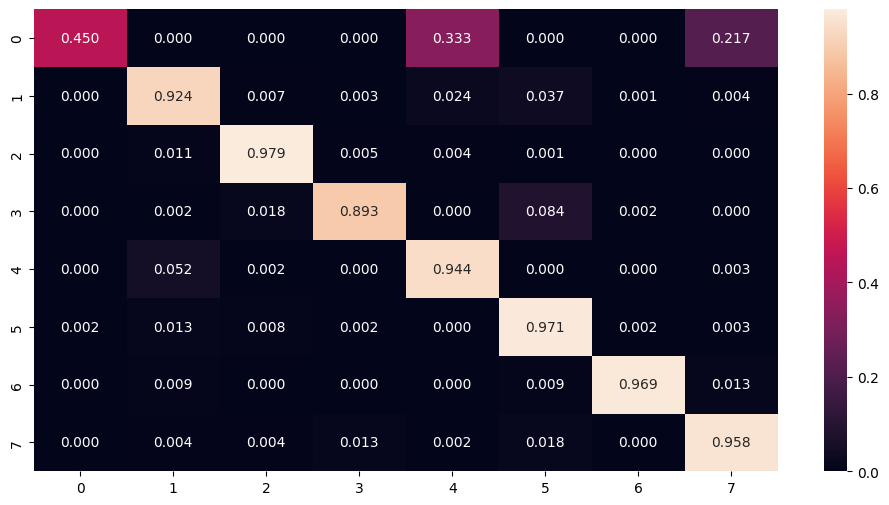

In [42]:
preds = []
ground_truth = []

for images, targets in test_loader:
    logits = model_Conv_II(images.to(device))
    preds_aux = [np.argmax(x) for x in logits.cpu().detach().numpy()]
    preds.extend(preds_aux)
    ground_truth.extend(targets.numpy())
vcpi_util.show_confusion_matrix(ground_truth, preds, 8)

Counter({2: 1770, 1: 1740, 4: 1590, 5: 1500, 6: 1170, 3: 1140, 7: 1110, 0: 180})


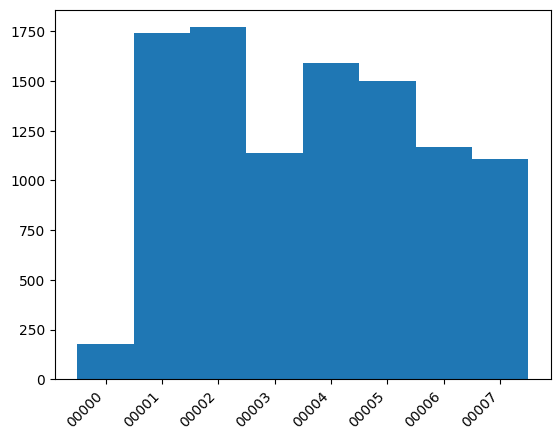

In [43]:
target_list = []

for images, targets in train_loader:
    target_list.extend(targets)
vcpi_util.show_histogram(target_list, train_set.classes)